# lab6 - Wordnet (słowosieć)

The task concentrates on the usage of a WordNet for finding semantic relations between words and expressions.

In [1]:
import nltk
from nltk.corpus import wordnet as wn
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import chain
nltk_path =  "../nltk_data"
if nltk_path not in nltk.data.path:
    nltk.data.path.append(nltk_path)

In [2]:
def ss(name, index=None):
    return wn.synsets(name)[index] if index is not None else wn.synsets(name)

## Task

1. Read the [Wordnet API](http://api.slowosiec.clarin-pl.eu/docs/index.html)
2. Get acquainted with [semantic relations](http://nlp.pwr.wroc.pl/narzedzia-i-zasoby/narzedzia/disaster/25-wiedza/81-relacje-w-slowosieci) in WordNet.

3. Find all meaning of the _szkoda_ **noun** and display all their synonyms.

http://plwordnet.pwr.wroc.pl/wordnet/8061a7c8-5d15-11e9-bb72-0b543675d8e2

In [3]:
[
    (s, s.lemmas())
    for s in
    ss("szkoda")
]

[(Synset('szkoda.n.01'), [Lemma('szkoda.n.01.szkoda')]),
 (Synset('szkoda.n.02'),
  [Lemma('szkoda.n.02.szkoda'),
   Lemma('szkoda.n.02.utrata'),
   Lemma('szkoda.n.02.strata'),
   Lemma('szkoda.n.02.uszczerbek')]),
 (Synset('żałować.v.03'),
  [Lemma('żałować.v.03.żałować'),
   Lemma('żałować.v.03.żal'),
   Lemma('żałować.v.03.szkoda')])]

4. Find closure of **hypernymy** relation for the first meaning of the _wypadek drogowy_ expression.

Create diagram of the relations as a directed graph.

http://plwordnet.pwr.wroc.pl/wordnet/ab6804d4-5d16-11e9-974d-3bda217843dd

(wyświetl wizualizację graficzną)

5. Find direct **hyponyms** of _wypadek<sub>1</sub>_ noun.

In [4]:
[s for s in ss("wypadek", 0).hyponyms()]

[Synset('kapotaż.n.01'),
 Synset('karambol.n.01'),
 Synset('katastrofa_budowlana.n.01'),
 Synset('kolizja.n.02'),
 Synset('stłuczka.n.01'),
 Synset('tąpnięcie.n.01'),
 Synset('wykolejenie.n.02'),
 Synset('wypadek_jądrowy.n.01'),
 Synset('wypadek_komunikacyjny.n.01'),
 Synset('zachłyśnięcie.n.01'),
 Synset('zawał.n.02')]

6. Find second-order **hyponyms** of the same noun.

In [5]:
[(s, "->", s.hyponyms()) for s in ss("wypadek", 0).hyponyms()]

[(Synset('kapotaż.n.01'), '->', []),
 (Synset('karambol.n.01'), '->', []),
 (Synset('katastrofa_budowlana.n.01'), '->', []),
 (Synset('kolizja.n.02'), '->', [Synset('kolizja_drogowa.n.01')]),
 (Synset('stłuczka.n.01'), '->', [Synset('czołówka.n.09')]),
 (Synset('tąpnięcie.n.01'), '->', []),
 (Synset('wykolejenie.n.02'), '->', []),
 (Synset('wypadek_jądrowy.n.01'), '->', []),
 (Synset('wypadek_komunikacyjny.n.01'),
  '->',
  [Synset('wypadek_drogowy.n.01')]),
 (Synset('zachłyśnięcie.n.01'), '->', []),
 (Synset('zawał.n.02'), '->', [Synset('obwał.n.01')])]

7. Display as a directed graph (with labels for the edges) semantic relations between the following groups of lexemes:

In [6]:
def neighbors(synset):
    def points_to_synsets(s, r):
        if not r.startswith("_") and hasattr(s, r) and callable(getattr(s, r)): 
            try:
                l = list(getattr(s, r)())
                return len(l)>0 and type(l[0]) == type(s)
            except:
                return False
        return False
    return [
        (r, getattr(synset, r)()) for r in dir(synset) if points_to_synsets(synset, r)
    ]

In [7]:
def synset_graph(synsets):
    edges = set()
    while not all(any(s in e[:2] for e in edges) for s in synsets):
        processed = [e[0] for e in edges]
        to_process = [e[1] for e in edges]
        to_process = [s for s in to_process + synsets if s not in processed]
        for s in to_process:
            neigh = neighbors(s)
            for e_type, ns in neigh:
                edges = edges.union({(s, n, e_type) for n in ns})
    vertices = list(chain.from_iterable(e[:2] for e in edges))
    redundant_vertices = [
        v for v in set(vertices) 
        if v not in synsets and 
        (len([ver for ver in vertices if ver==v]) == 1)
    ]
    
    return [
        e for e in edges 
        if (e[0] in synsets or e[1] in synsets) 
        and e[0] not in redundant_vertices 
        and e[1] not in redundant_vertices
    ]

In [8]:
def draw_synset_graph(synset_graph):
    edges = {(e[0]._name, e[1]._name): e[2] for e in synset_graph}
    G = nx.DiGraph()
    G.add_edges_from(list(edges.keys()))
    pos = nx.spring_layout(G)
    plt.figure(figsize=(20, 20))    
    nx.draw(
        G,pos,edge_color='black',width=1,linewidths=1,
        node_size=3000,node_color='pink',alpha=0.9,
        labels={node:node for node in G.nodes()}
    )
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edges,font_color='red')
    plt.show()

   a) szkoda<sub>2</sub>, strata<sub>1</sub>, uszczerbek<sub>1</sub>, szkoda majątkowa<sub>1</sub>, 
      uszczerbek na zdrowiu<sub>1</sub>, krzywda<sub>1</sub>, niesprawiedliwość<sub>1</sub>, nieszczęście<sub>2</sub>.
      

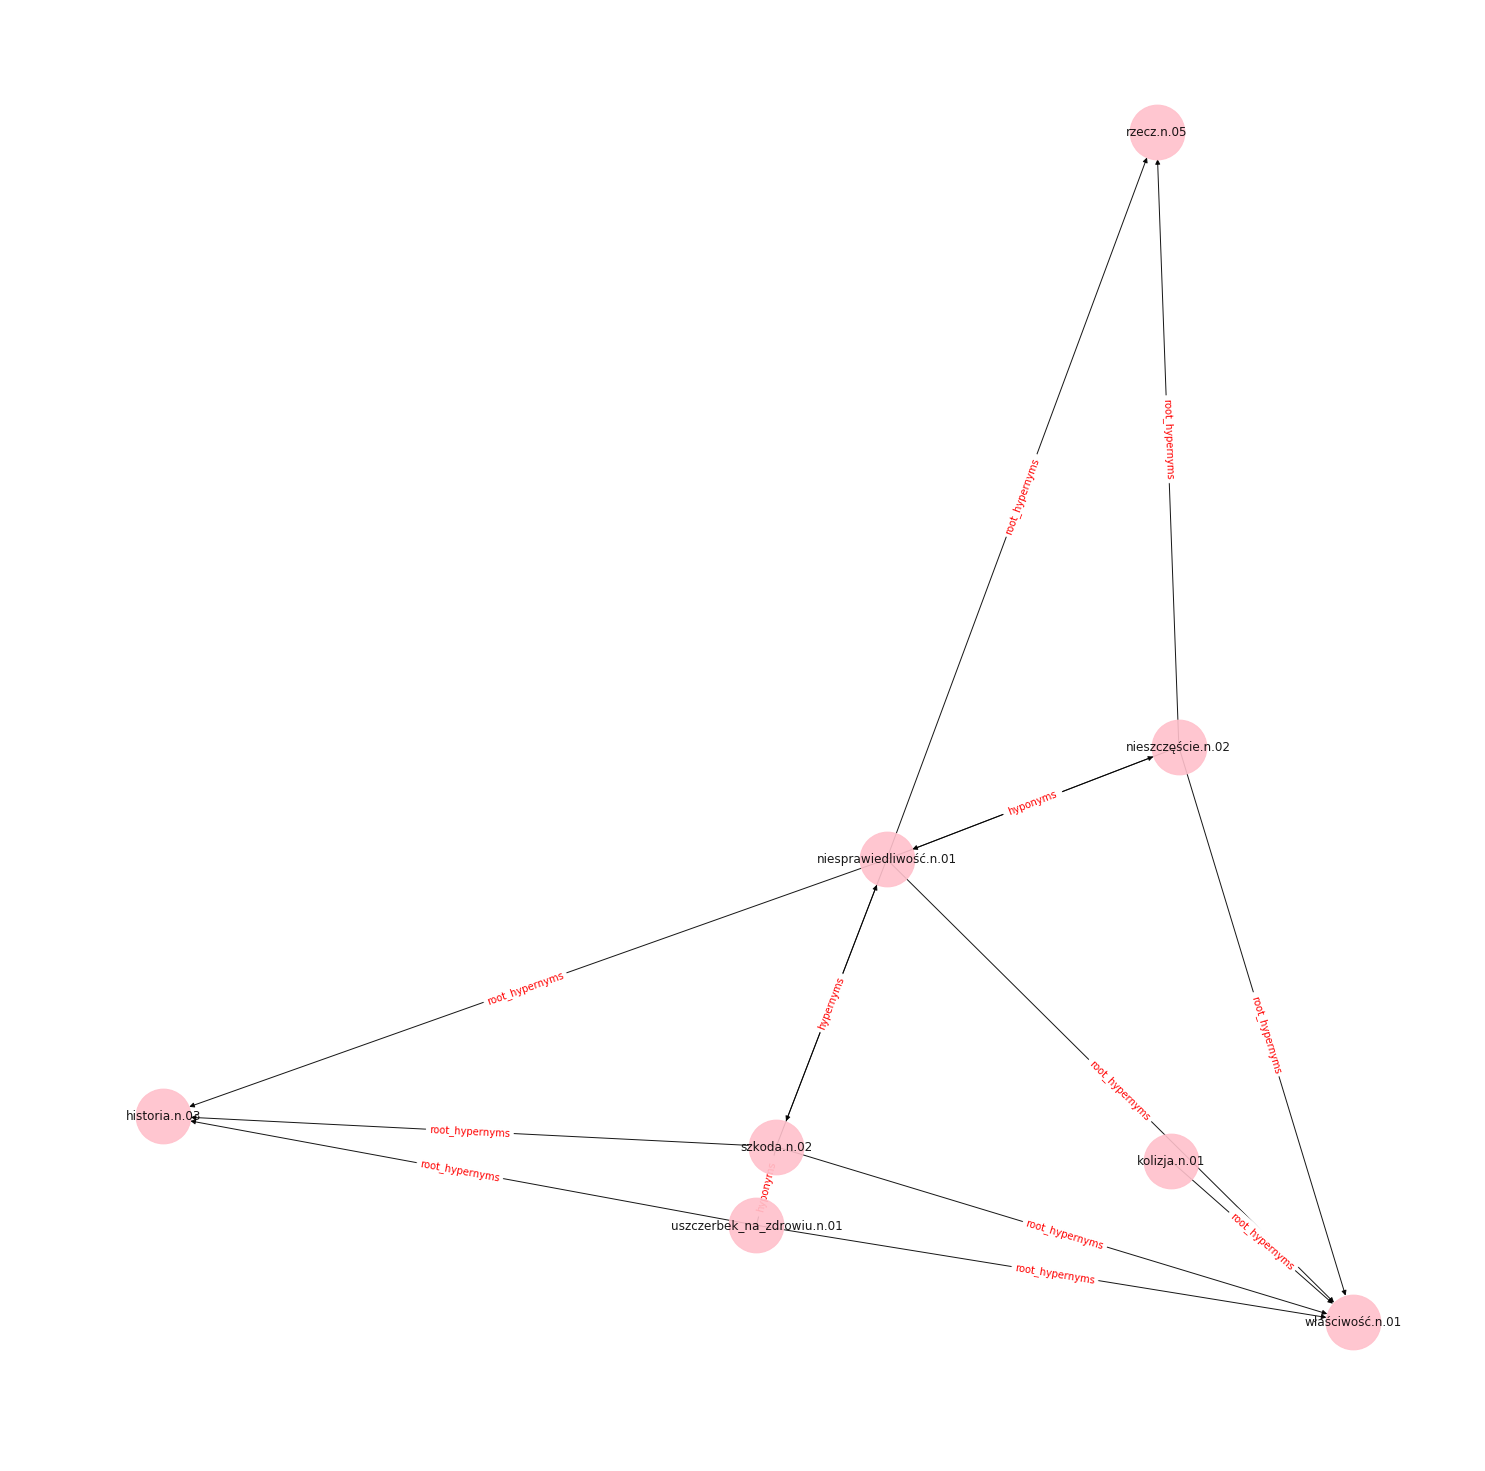

In [9]:
synsets = [
    ss("szkoda",0),
    ss("kolizja", 0),
    ss("uszczerbek", 0),
    ss("uszczerbek_na_zdrowiu", 0),
    ss("krzywda", 0),
    ss("niesprawiedliwość", 0),
    ss("nieszczęście", 1)
]
g= synset_graph(synsets)
draw_synset_graph(g)

   b) wypadek<sub>1</sub>, wypadek komunikacyjny<sub>1</sub>, kolizja<sub>2</sub>, zderzenie<sub>2</sub>,
      kolizja drogowa<sub>1</sub>, bezkolizyjny<sub>2</sub>, katastrofa budowlana<sub>1</sub>, wypadek
      drogowy<sub>1</sub>.
      

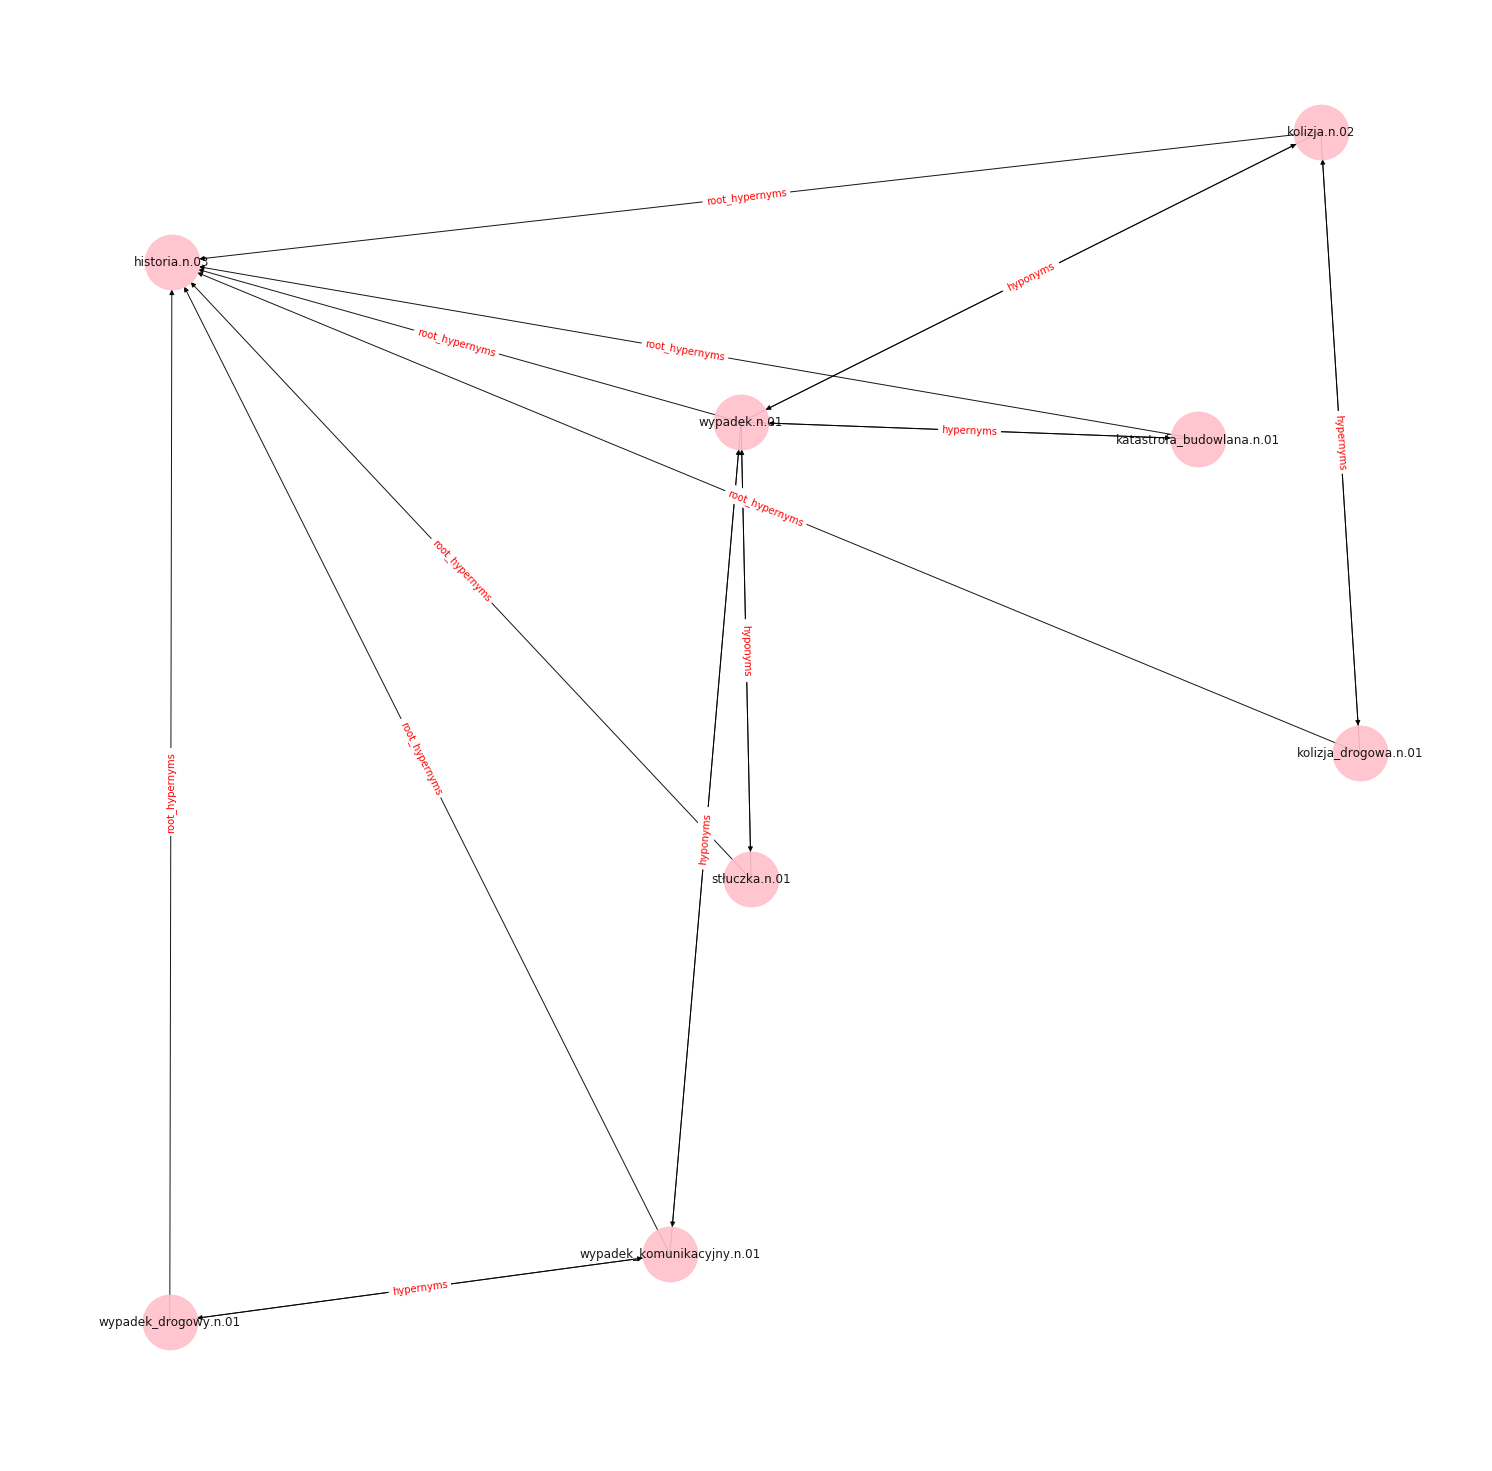

In [10]:
synsets = [
   ss("wypadek", 0),
    ss("wypadek_komunikacyjny", 0),
    ss("kolizja", 1),
    ss("zderzenie", 1),
    ss("kolizja_drogowa", 0),
    ss("bezkolizyjny", 1),
    ss("katastrofa_budowlana", 0),
    ss("wypadek_drogowy", 0)
]
synsets
g = synset_graph(synsets)
draw_synset_graph(g)

8. Find the value of [Leacock-Chodorow semantic similarity measure](ftp://www-vhost.cs.toronto.edu/public_html/public_html/pub/gh/Budanitsky+Hirst-2001.pdf)
   between following pairs of lexemes:
   1. szkoda<sub>2</sub> - wypadek<sub>1</sub>,
   1. kolizja<sub>2</sub> - szkoda majątkowa<sub>1</sub>,
   1. nieszczęście<sub>2</sub> - katastrofa budowlana<sub>1</sub>.

In [11]:
[
    (s1, s2, wn.lch_similarity(s1, s2))
    for (s1, s2) in [
        (ss("katastrofa", 0), ss("wypadek", 0)),
        (ss("kolizja", 1), ss("szkoda", 0)),
        (ss("nieszczęście", 0), ss("katastrofa", 1))
    ]
]

[(Synset('koniec.n.05'), Synset('wypadek.n.01'), 3.028522096376982),
 (Synset('kolizja.n.02'), Synset('szkoda.n.01'), None),
 (Synset('cios.n.02'), Synset('katastrofa.n.02'), 3.4339872044851463)]

## Hints

1. WordNet is a semantic dictionary that has the following features:
   1. it identifies **the meanings** of the words, i.e. _zamek_ in the sense of a _castle_ and _zamek_ in the sense of a  _tool_ have two distinct representations,
   1. it describes these meaning using **semantic relations**, e.g. _zamek<sub>1</sub>_ is a **hyponym** of
      _budynek<sub>1</sub>_ and _zamek<sub>2</sub>_ is a **hypernym** of _zatrzasku<sub>2</sub>_.
1. The meaning of a lexeme is identified by an index, e.g. _zamek<sub>1</sub>_ identifies the first meaning and
   _zamek<sub>2</sub>_ the second, etc.
1. WordNet defines **lexemes** and **synsets**. The lexemes roughly correspond to words, i.e. we say that a lexeme with
   an index _has_ a particular meaning, e.g.  _zamek<sub>2</sub>_  refers to a tool for closing things.
   But that meaning is obtained thanks to its participation to a particular _synset_. A synset is a set of lexemes that
   share meaning. E.g. _szkoda<sub>2</sub>_, _uszczerbek<sub>1</sub>_, _strata<sub>1</sub>_ and _utrata<sub>1</sub>_
   belong to one synset. As a consequence the definition and most of the relations are attached to a synset, rather than
   a lexeme. Lexemes belonging to a particular synset are called synonyms.
1. The [NLTK](https://www.nltk.org/) library has an [implementation](http://www.nltk.org/howto/wordnet.html) of Leacock-Chodorow measure, 
   but it does not integrate with the Polish WordNet.
1. The [pywnxml](https://github.com/ppke-nlpg/pywnxml) library allows for reading the Polish WordNet, but it lacks that
   measure.
1. The contents of the Plish WordNet may also be accessed by a [web API](http://api.slowosiec.clarin-pl.eu/docs/index.html)